# Notebook pour l'entrainement et l'exécution d'un réseau fasterRCNN pour la détection de la tête des nageurs

### Connexion à Google Drive où sont stockées les données annotées et le modèle déjà entrainé à ce jour

Le chemin en argument de os.chdir doit être de la forme 'gdrive/My Drive/votre_dossier' . Le notebook doit être placé à l'intérieur de 'votre_dossier'.

Pour l'entrainement :

A l'intérieur de 'votre_dossier' doit se trouver un dossier 'swimmer' . Ce dossier 'swimmer' doit contenir d'une part le csv 'labels_nageur.csv' contenant les annotations et un dossier 'images' contenant toutes les images nécessaires à l'entrainement.

In [1]:
#import pycotools
import os

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/Stage_LIRIS/pytorch_object_detection') 



Mounted at /content/gdrive


'/content/gdrive/My Drive/Stage_LIRIS/pytorch_object_detection'

### Import des différents modules nécessaires

Les modules engine et utils en particulier sont à télécharger depuis le github : https://github.com/pytorch/vision/tree/master/references/detection et à déposer dans 'votre_dossier' .


In [2]:
import numpy as np
import torch
import torch.utils.data
import torchvision
from PIL import Image, ImageDraw
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
from torchvision.transforms import transforms as T  #transforms du git ou de pytorch??
import matplotlib.pyplot as plt
import cv2

### Création de la classe « SwimmerDataset »


In [ ]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin","xmax", "ymax"]].values 
   
    return boxes_array

class SwimmerDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "images")))
        self.path_to_data_file = data_file
    
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx]) 
        img = Image.open(img_path).convert("RGB") 
        box_list = parse_one_annot(self.path_to_data_file, 
        self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        
        # only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,
        0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            return img, target
        
    def __len__(self):
        return len(self.imgs)


### Définition de *get_model* et *get_transform*

On commence par créer une fonction *get_model* qui va instancier un modèle fasterrcnn_resnet50_fpn préentrainé duquel on réinitialise la dernière couche chargée de la prédiction des bounding box. On définit ensuite une seconde fonction *get_transform* qui va concaténer toutes les transformations appliquées aux data avant d'être entrainées ( transformation en tensor puis data augmentation ).

In [4]:
def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        
   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
    
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
   return model

def get_transform(train):
    transformslist = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transformslist.append(T.ToTensor())

    if train:
        # data augmentation
        transformslist.append(T.RandomHorizontalFlip(0.5))
        #transformslist.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2))
        #transformslist.append(T.RandomRotation(degrees=30))

    return T.Compose(transformslist)

### Création du dataset d'entrainement et de validation

Ici on instancie notre dataset d'entrainement (80%) et de validation (20%) en faisant un shuffle au préalable. 

C'est dans *data_loader_train* que l'on peut changer le batch_size pour l'entrainement.

In [ ]:
# use our dataset and defined transformations
dataset = SwimmerDataset(root= "swimmer",
          data_file= "swimmer/labels_nageur.csv",
          transforms = get_transform(train=True))

dataset_test = SwimmerDataset(root= "swimmer",
               data_file= "swimmer/labels_nageur.csv",
               transforms = get_transform(train=False))

# split the dataset between train and test set

#torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

nb_test = int(0.2*len(dataset))
dataset = torch.utils.data.Subset(dataset, indices[:-nb_test])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-(nb_test):])

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=0,
              collate_fn=utils.collate_fn) #batch_size here
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=0,
         collate_fn=utils.collate_fn)
print("Le dataset contient {} images, {} pour l'entrainement et {} pour la validation".format(len(indices), len(dataset), len(dataset_test)))



We have: 153 examples, 123 are training and 30 testing


### Instanciation du modèle RCNN

On commence par choisir comme device le GPU si la technologie CUDA est disponible, ce qui accélère grandement les calculs sinon on se place sur le CPU.

Puis on instancie notre modèle RCNN ainsi que l'optimiseur associé (ici SGD). On peut changer lr (learning_rate), momentum et weight_decay .

On peut choisir de faire décroitre le learning rate d'un facteur *gamma* tous les *step_size* epoch via *lr_scheduler*. 

In [6]:
# use GPU if CUDA is available otherwise use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
num_classes = 2

# get the model 
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate over epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.5)

### Entrainement du réseau

Dans la cellule suivante on procède à l'entrainement du réseau. On peut choisir le nombre d'epoch et également la fréquence à laquelle la loss est affiché pendant l'entrainement.
print_freq = 10 signifie que tous les 10 batch, on affiche la loss.

Au fur et à mesure de l'entrainement l'évaluateur affiche les différentes métriques de performances en précision et en recall pour plusieurs échelles différentes et plusieurs IoU ( intersection over union entre la box annotée et la box prédite ) sur le dataset de validation.


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  # train for one epoch
  train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10) #print every print_freq batches
    
  # update the learning rate
  lr_scheduler.step()

  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/62]  eta: 0:00:37  lr: 0.000174  loss: 0.9009 (0.9009)  loss_classifier: 0.7813 (0.7813)  loss_box_reg: 0.0812 (0.0812)  loss_objectness: 0.0347 (0.0347)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 0.5968  data: 0.0209  max mem: 3634
Epoch: [0]  [10/62]  eta: 0:00:25  lr: 0.001811  loss: 0.2899 (0.4864)  loss_classifier: 0.1531 (0.3530)  loss_box_reg: 0.0986 (0.0957)  loss_objectness: 0.0195 (0.0296)  loss_rpn_box_reg: 0.0047 (0.0080)  time: 0.4992  data: 0.0151  max mem: 4025
Epoch: [0]  [20/62]  eta: 0:00:21  lr: 0.003449  loss: 0.2851 (0.3915)  loss_classifier: 0.1242 (0.2441)  loss_box_reg: 0.0993 (0.1107)  loss_objectness: 0.0195 (0.0304)  loss_rpn_box_reg: 0.0039 (0.0064)  time: 0.5063  data: 0.0144  max mem: 4026
Epoch: [0]  [30/62]  eta: 0:00:16  lr: 0.005087  loss: 0.2600 (0.3443)  loss_classifier: 0.0809 (0.1892)  loss_box_reg: 0.1483 (0.1255)  loss_objectness: 0.0105 (0.0240)  loss_rpn_box_reg: 0.0029 (0.0056)  time: 0.5165  data: 0.0141  max mem: 4026
Epoch: [

KeyboardInterrupt: ignored

### Sauvegarde du modèle entrainé 

On peut ensuite sauvegarder les poids du modèle entrainé sur le drive.

In [ ]:
#Save the model
torch.save(model.state_dict(), "swimmer/model_swimmer")

### Charger un modèle déjà existant et le tester sur une image ou une vidéo

On définit le chemin vers le fichier contenant les poids du RCNN obtenus à la suite de l'entrainement.

La première cellule permet de tester directement le modèle sur les images du dataset de validation. Pour cela il suffit de choisir l'indice de l'image à tester (idx)  

La deuxième cellule permet de tester le modèle sur une vidéo zoomée. Il faut préciser le chemin vers la vidéo. Sans accélération par un GPU, les calculs sont longs (environ 4 secondes par frame de vidéo de taille 256x256) . Il faut préciser le chemin vers la vidéo.

tensor([[[0.1882, 0.1922, 0.2039,  ..., 0.2000, 0.2039, 0.1804],
         [0.1569, 0.1843, 0.2118,  ..., 0.1451, 0.1294, 0.1451],
         [0.2118, 0.2196, 0.2196,  ..., 0.1490, 0.1451, 0.1490],
         ...,
         [0.1765, 0.1725, 0.1647,  ..., 0.1647, 0.1490, 0.1451],
         [0.1804, 0.1843, 0.1765,  ..., 0.1294, 0.1765, 0.1294],
         [0.2039, 0.2000, 0.2039,  ..., 0.1255, 0.1373, 0.1216]],

        [[0.6078, 0.6157, 0.6000,  ..., 0.5922, 0.5961, 0.5961],
         [0.5765, 0.6039, 0.6078,  ..., 0.5765, 0.5647, 0.5804],
         [0.6196, 0.6275, 0.6157,  ..., 0.5804, 0.5765, 0.5882],
         ...,
         [0.5922, 0.5882, 0.5804,  ..., 0.5647, 0.5451, 0.5608],
         [0.5804, 0.5882, 0.5961,  ..., 0.4980, 0.5451, 0.5137],
         [0.6196, 0.6157, 0.6235,  ..., 0.5137, 0.5255, 0.5137]],

        [[0.6902, 0.6980, 0.6902,  ..., 0.7020, 0.7059, 0.6980],
         [0.6627, 0.6902, 0.7059,  ..., 0.6824, 0.6706, 0.7020],
         [0.7098, 0.7176, 0.7098,  ..., 0.6863, 0.6824, 0.

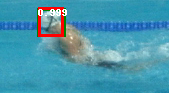

In [ ]:
# test sur une image du dataset de validation

# use GPU if CUDA is available otherwise use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("swimmer/modelfin_swimmer", map_location=device))

idx = 0
img, _ = dataset_test[idx]

label_boxes = np.array(dataset_test[idx][1]["boxes"])

#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)

# rouge = prediction, vert = box annotee
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="green", width =3)

for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    
    if score > 0.8:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ="red", width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))

image

In [ ]:
# test sur une video

# use GPU if CUDA is available otherwise use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("swimmer/modelfin_swimmer", map_location=device))

cap = cv2.VideoCapture('swimmer/zoom1.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float 
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # float
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('swimmer/outputRCNN_zoom1.avi', fourcc, fps, (int(width),  int(height)))
length = cap.get(cv2.CAP_PROP_FRAME_COUNT)

seuil=0.5

#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():

  while(True):
      # Capture frame-by-frame
      ret, frame = cap.read()
      num_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
      print(str(num_frame)+' sur '+str(length))

      if ret :

        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #passage en RGB 
        im_tensor = T.ToTensor()(img)[0].to(device) #conversion en tensor 

       
        detection = loaded_model([im_tensor])

        
        N = len(detection[0]['boxes']) #nombre de detection 
        for n in range(N) : 
          xmin, ymin,xmax, ymax = detection[0]['boxes'][n]
          score = detection[0]['scores'][n].item()

          if score>= seuil : 
            top_left = (int(xmin.item()), int(ymin.item()))
            bottom_right = (int(xmax.item()), int(ymax.item()))
            frame = cv2.rectangle(frame, top_left,bottom_right , (0,255,0), 2)
            
        out.write(frame)

      else :
          break

  cap.release()
  out.release()
  cv2.destroyAllWindows()

1.0 sur 960.0
2.0 sur 960.0
3.0 sur 960.0
4.0 sur 960.0
5.0 sur 960.0
6.0 sur 960.0
7.0 sur 960.0
8.0 sur 960.0
9.0 sur 960.0
10.0 sur 960.0
11.0 sur 960.0
12.0 sur 960.0
13.0 sur 960.0
14.0 sur 960.0
15.0 sur 960.0
16.0 sur 960.0
17.0 sur 960.0
18.0 sur 960.0
19.0 sur 960.0
20.0 sur 960.0
21.0 sur 960.0
22.0 sur 960.0
23.0 sur 960.0
24.0 sur 960.0
25.0 sur 960.0
26.0 sur 960.0
27.0 sur 960.0
28.0 sur 960.0
29.0 sur 960.0
30.0 sur 960.0
31.0 sur 960.0
32.0 sur 960.0
33.0 sur 960.0
34.0 sur 960.0
35.0 sur 960.0
36.0 sur 960.0
37.0 sur 960.0
38.0 sur 960.0
39.0 sur 960.0
40.0 sur 960.0
41.0 sur 960.0
42.0 sur 960.0
43.0 sur 960.0
44.0 sur 960.0
45.0 sur 960.0
46.0 sur 960.0
47.0 sur 960.0
48.0 sur 960.0
49.0 sur 960.0
50.0 sur 960.0
51.0 sur 960.0
52.0 sur 960.0
53.0 sur 960.0
54.0 sur 960.0
55.0 sur 960.0
56.0 sur 960.0
57.0 sur 960.0
58.0 sur 960.0
59.0 sur 960.0
60.0 sur 960.0
61.0 sur 960.0
62.0 sur 960.0
63.0 sur 960.0
64.0 sur 960.0
65.0 sur 960.0
66.0 sur 960.0
67.0 sur 960.0
68.0